# The effects of smoothing and start time estimation

## Poisson generator

In [26]:
import numpy as np
rng = np.random.default_rng()
s = rng.poisson(5, 100)
s

array([ 3,  2,  3,  5,  7,  8,  6,  3,  4,  3,  8,  6,  2,  6,  5,  7,  5,
        4,  6,  6,  2,  5,  8,  6,  8,  5,  0,  3,  5,  1,  6,  4,  8,  3,
        2,  5,  5,  1,  6,  2,  4,  5,  5,  5,  6,  8,  2,  5,  5,  1,  9,
        5,  4,  4,  4,  4,  6,  5,  5,  2,  4,  3,  7,  2,  3,  2,  5,  6,
        9, 10,  7,  7,  0,  6,  1,  2,  4,  2,  5,  6,  4,  5,  2,  6, 10,
        5,  4,  5,  0,  8,  5,  7,  5,  3,  7,  4,  6,  5, 12,  5])

## Noisy count

In [88]:
from dp_counter import dp_counter

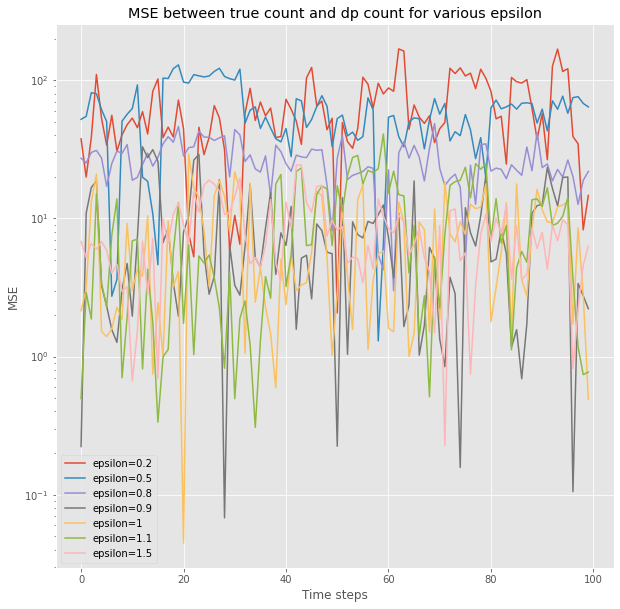

In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

count_true = np.cumsum(s)
x_range = np.arange(len(count_true))
epsilon_range = [0.2, 0.5, 0.8, 0.9, 1, 1.1, 1.5]

plt.figure(figsize=(10, 10))
for epsilon in epsilon_range:
    plt.plot(x_range, abs((dp_counter(s, epsilon=epsilon, stream_item_reader=lambda x: x) - count_true)),
            label=f'epsilon={epsilon}')
plt.yscale('log')
plt.xlabel('Time steps')
plt.ylabel('MSE')
plt.title('MSE between true count and dp count for various epsilon')
plt.legend()
plt.show()

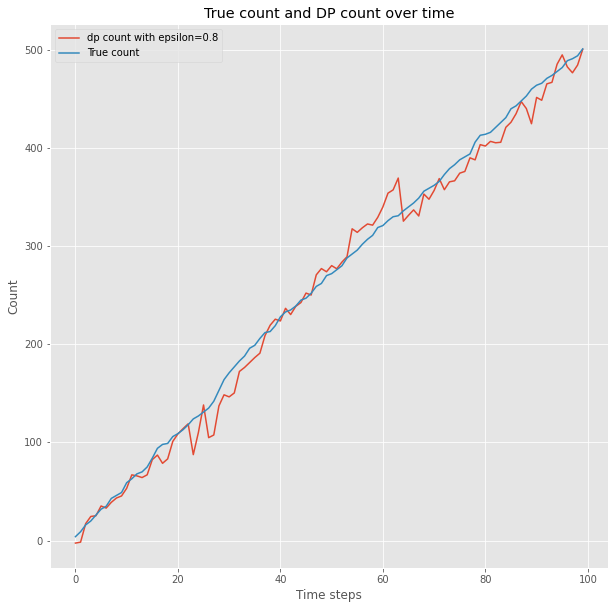

In [21]:
count_true = np.cumsum(s)
x_range = np.arange(len(count_true))
epsilon = 0.8

plt.figure(figsize=(10, 10))
plt.plot(x_range, dp_counter(s, epsilon=epsilon, stream_item_reader=lambda x: x),
        label=f'dp count with epsilon={epsilon}')
plt.plot(x_range, count_true, label='True count')
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('True count and DP count over time')
plt.legend()
plt.show()

## Experiment

In [39]:
lambda_number = 10
poisson_lambda_range = [10**(i/3) for i in np.linspace(-5.0, 5.0, lambda_number)]
epsilon_range = [0.2, 0.5, 0.8, 0.9, 1, 1.1, 1.5]
iter_number = 1000
time_step_number = 100

freq = []
for poisson_lambda in poisson_lambda_range:
    for epsilon in epsilon_range:
        for i in range(iter_number):
            rng = np.random.default_rng()
            s = rng.poisson(poisson_lambda, time_step_number)
            count_dp = np.array(dp_counter(s, epsilon=epsilon, stream_item_reader=lambda x: x))
            is_decreasing = any((count_dp[1:] - count_dp[:-1]) < 0)
            freq.append({'lambda': poisson_lambda, 'epsilon': epsilon, 'is_decreasing': is_decreasing})

In [50]:
import pandas as pd
df_freq = pd.DataFrame.from_records(freq)
df_plot = df_freq.groupby(['lambda', 'epsilon']).is_decreasing.sum() / iter_number

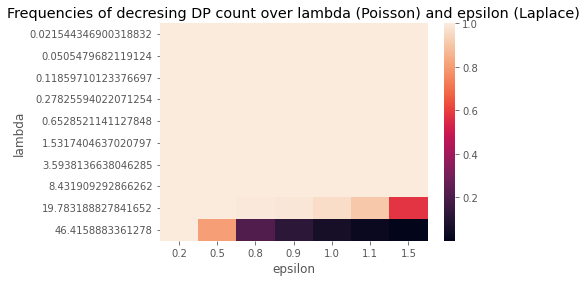

In [54]:
import seaborn as sns

ax = sns.heatmap(df_plot.unstack())
plt.title('Frequencies of decresing DP count over lambda (Poisson) and epsilon (Laplace)')
plt.show()

## Smoothing strategies

In [82]:
import pandas as pd

df_res = pd.read_csv('smooth_exp_results_20N.csv')

In [79]:
time_step_range_length = 3
time_step_range = [2**(5*(i+1)) for i in range(time_step_range_length)]
df_res['time_step_number'] = np.tile(np.repeat(time_step_range, 20), 8)

ValueError: Length of values (480) does not match length of index (1296)

In [83]:
df_plot = df_res[df_res.is_decreasing][['lambda', 'epsilon', 'time_step_number', 'mse_true_dp', 'mse_true_smooth']]
df_plot = df_plot.groupby(['time_step_number', 'lambda', 'epsilon']).mean()
df_plot['dp_smooth_rate'] = (df_plot.mse_true_smooth - df_plot.mse_true_dp) / df_plot.mse_true_dp

df_plot.drop(['mse_true_dp', 'mse_true_smooth'], axis=1, inplace=True)

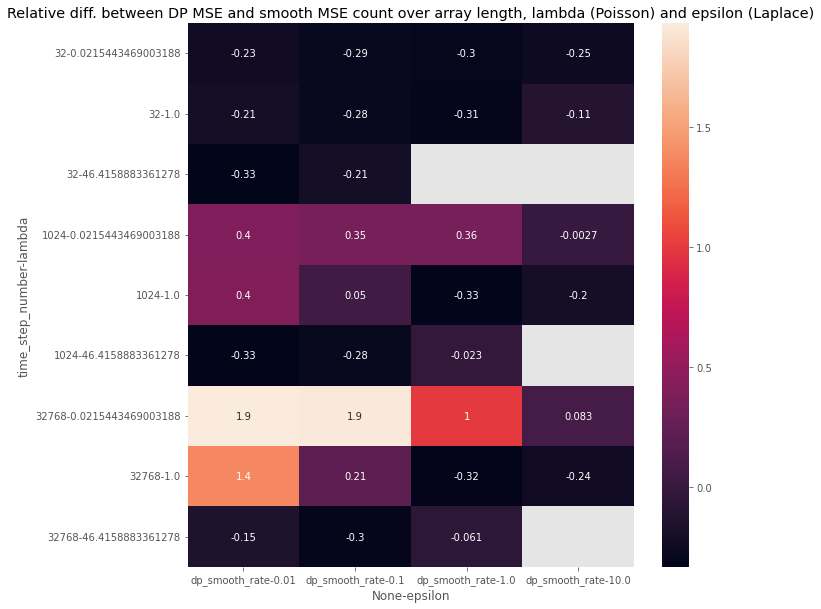

In [84]:
import seaborn as sns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_plot.unstack(level=2),annot=True)
plt.title('Relative diff. between DP MSE and smooth MSE count over array length, lambda (Poisson) and epsilon (Laplace)')
plt.show()

In [87]:
print(df_plot.unstack(level=2).to_latex(index=True))

\begin{tabular}{llrrrr}
\toprule
      & {} & \multicolumn{4}{l}{dp\_smooth\_rate} \\
      & epsilon &          0.01  &     0.10  &     1.00  &     10.00 \\
time\_step\_number & lambda &                &           &           &           \\
\midrule
32    & 0.021544  &      -0.227683 & -0.285827 & -0.301802 & -0.254193 \\
      & 1.000000  &      -0.205101 & -0.283073 & -0.305196 & -0.114550 \\
      & 46.415888 &      -0.330916 & -0.208132 &       NaN &       NaN \\
1024  & 0.021544  &       0.397249 &  0.349709 &  0.356081 & -0.002660 \\
      & 1.000000  &       0.403531 &  0.049724 & -0.331120 & -0.204620 \\
      & 46.415888 &      -0.328583 & -0.283315 & -0.022910 &       NaN \\
32768 & 0.021544  &       1.931838 &  1.922531 &  1.001584 &  0.083433 \\
      & 1.000000  &       1.373006 &  0.208206 & -0.316816 & -0.236066 \\
      & 46.415888 &      -0.149854 & -0.304789 & -0.061381 &       NaN \\
\bottomrule
\end{tabular}



## Epsilon

In [9]:
import pandas as pd

df_eps = pd.read_csv('smooth_exp_results_epsilon.csv')

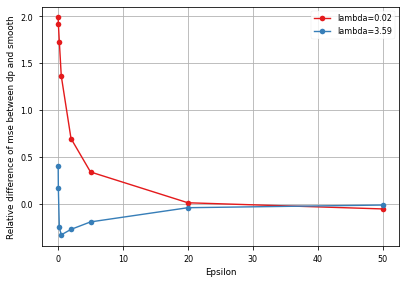

In [24]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
#plt.figure(figsize=(10, 10))
df_plot = df_eps.groupby(['lambda', 'epsilon']).mean().reset_index()
df_plot['dp_smooth_rate'] = (df_plot.mse_true_smooth - df_plot.mse_true_dp) / df_plot.mse_true_dp

for lambda_poisson in df_plot['lambda'].drop_duplicates():
    df = df_plot.loc[df_plot['lambda'] == lambda_poisson]
    plt.plot(df.epsilon, df.dp_smooth_rate,
            label=f'lambda={round(lambda_poisson, 2)}', marker='o')
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('Relative difference of mse between dp and smooth')
plt.legend()
plt.savefig('results/results_epsilon.png', bbox_inches='tight')
plt.show()

## Lambda

In [111]:
import pandas as pd

df_lam = pd.read_csv('smooth_exp_results_lambda.csv')

In [105]:
df_lam.time_step_number.drop_duplicates()

0    32768
Name: time_step_number, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


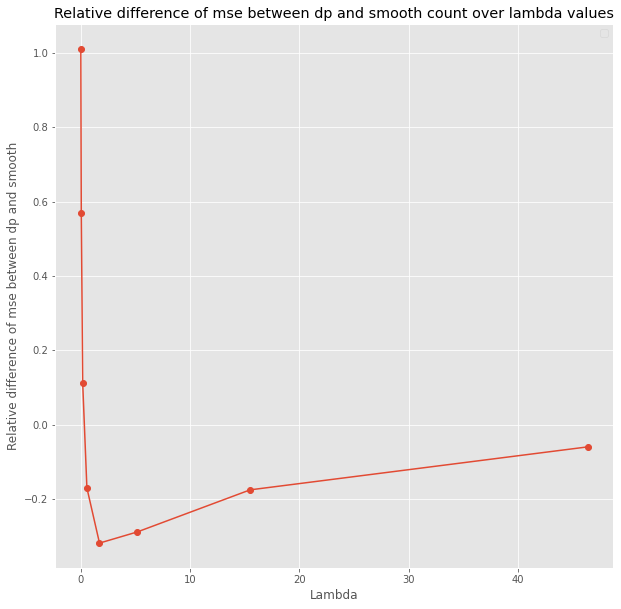

In [112]:
plt.figure(figsize=(10, 10))
df_plot = df_lam.groupby(['lambda', 'epsilon']).mean().reset_index()
df_plot['dp_smooth_rate'] = (df_plot.mse_true_smooth - df_plot.mse_true_dp) / df_plot.mse_true_dp

plt.plot(df_plot['lambda'], df_plot.dp_smooth_rate, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Relative difference of mse between dp and smooth')
plt.title('Relative difference of mse between dp and smooth count over lambda values')
plt.legend()
plt.show()

## Investigation

     pcost       dcost       gap    pres   dres
 0:  1.2610e+06 -3.3500e+06  2e+07  7e-01  7e+02
 1:  1.3892e+06 -1.2360e+06  4e+06  1e-01  1e+02
 2:  1.1629e+06  3.8404e+05  9e+05  2e-02  2e+01
 3:  9.8387e+05  7.9469e+05  2e+05  2e-03  2e+00
 4:  9.2227e+05  8.9274e+05  3e+04  2e-04  2e-01
 5:  9.0990e+05  9.0738e+05  3e+03  8e-06  9e-03
 6:  9.0860e+05  9.0850e+05  1e+02  2e-07  2e-04
 7:  9.0854e+05  9.0854e+05  4e+00  3e-09  3e-06
 8:  9.0854e+05  9.0854e+05  2e-01  3e-11  3e-08
Optimal solution found.


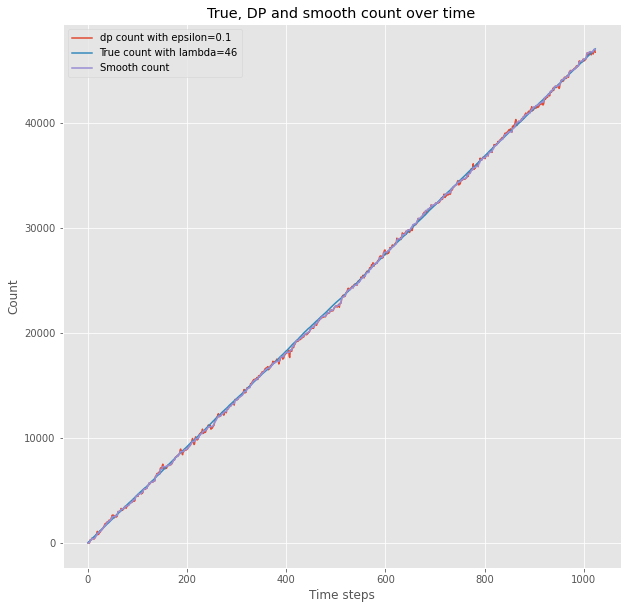

In [97]:
from dp_counter import dp_counter
from smooth import smooth, rv_index

epsilon = 0.1
lambda_poisson = 46
time_step_number = 1024

rng = np.random.default_rng(seed=42)
s = rng.poisson(lambda_poisson, time_step_number)
s = np.array(list(map(float, s)))
L = int(np.ceil(np.log(time_step_number)/np.log(2)))
rvidx = rv_index(time_step_number, L)
count_true = np.cumsum(s)
count_dp = np.array(dp_counter(s, epsilon=epsilon,
                               stream_item_reader=lambda x: x))
count_smooth = smooth(count_dp, rvidx)

x_range = np.arange(len(count_true))

plt.figure(figsize=(10, 10))
plt.plot(x_range, count_dp,
        label=f'dp count with epsilon={epsilon}')
plt.plot(x_range, count_true, label=f'True count with lambda={lambda_poisson}')
plt.plot(x_range, count_smooth, label=f'Smooth count')
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('True, DP and smooth count over time')
plt.legend()
plt.show()

     pcost       dcost       gap    pres   dres
 0:  1.3922e+06  2.3673e+06  2e+07  8e-01  6e+02
 1:  2.3146e+06  2.4585e+06  2e+06  9e-02  7e+01
 2:  2.5416e+06  2.5293e+06  4e+05  2e-02  1e+01
 3:  2.5854e+06  2.5559e+06  8e+04  2e-03  2e+00
 4:  2.5754e+06  2.5621e+06  2e+04  5e-04  4e-01
 5:  2.5665e+06  2.5636e+06  3e+03  3e-05  2e-02
 6:  2.5639e+06  2.5638e+06  1e+02  5e-07  4e-04
 7:  2.5638e+06  2.5638e+06  2e+00  6e-09  4e-06
 8:  2.5638e+06  2.5638e+06  3e-02  6e-11  4e-08
Optimal solution found.


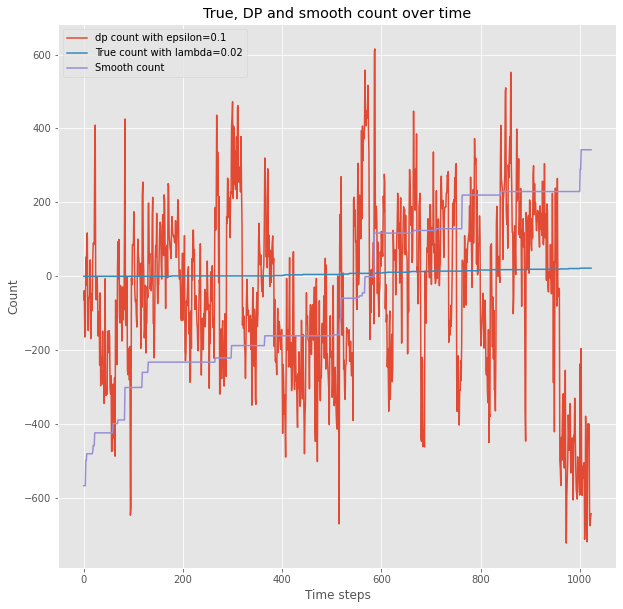

In [96]:
from dp_counter import dp_counter
from smooth import smooth, rv_index

epsilon = 0.1
lambda_poisson = 0.02
time_step_number = 1024

rng = np.random.default_rng(seed=42)
s = rng.poisson(lambda_poisson, time_step_number)
s = np.array(list(map(float, s)))
L = int(np.ceil(np.log(time_step_number)/np.log(2)))
rvidx = rv_index(time_step_number, L)
count_true = np.cumsum(s)
count_dp = np.array(dp_counter(s, epsilon=epsilon,
                               stream_item_reader=lambda x: x))
count_smooth = smooth(count_dp, rvidx)

x_range = np.arange(len(count_true))

plt.figure(figsize=(10, 10))
plt.plot(x_range, count_dp,
        label=f'dp count with epsilon={epsilon}')
plt.plot(x_range, count_true, label=f'True count with lambda={lambda_poisson}')
plt.plot(x_range, count_smooth, label=f'Smooth count')
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('True, DP and smooth count over time')
plt.legend()
plt.show()